# Process data

In [93]:
import csv
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [77]:
file_path="diabetes.csv"
# Read the CSV file
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip the header row
    data = []
    for row in reader:
        data.append([float(value) for value in row])

# Convert to numpy array for easier manipulation
data = np.array(data)

In [78]:
# Columns to replace zero values
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
columns_indices = [header.index(col) for col in columns_to_replace]

for col_idx in columns_indices:
    col_values = data[:, col_idx]
    non_zero_values = col_values[col_values != 0]
    mean_value = np.mean(non_zero_values)
    col_values[col_values == 0] = mean_value
    data[:, col_idx] = col_values

In [79]:
np.random.shuffle(data)

# Split into train (60%), validation (20%), and test (20%) sets
train_idx = int(0.6 * len(data))
valid_idx = int(0.8 * len(data))

train = data[:train_idx]
valid = data[train_idx:valid_idx]
test = data[valid_idx:]

In [80]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[:, :-1]  # Extract features (all columns except the last)
    y = dataframe[:, -1]   # Extract labels (last column)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, y.reshape(-1, 1)))  # Concatenate X and y back together

    return data, X, y

In [81]:
train, X_train, y_train=scale_dataset(train,oversample=True)
valid, X_valid, y_valid=scale_dataset(valid)
test, X_test, y_test=scale_dataset(test)

# Random Forest Classifier

In [82]:
best_rf_model=RandomForestClassifier()
best_rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [92]:
print("\nRandom Forest Classification Report:")
y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.84       101
         1.0       0.68      0.75      0.71        53

    accuracy                           0.79       154
   macro avg       0.77      0.78      0.78       154
weighted avg       0.80      0.79      0.79       154



Random Forest Test Accuracy Score: 0.7922077922077922

Random Forest Confusion Matrix:
[[82 19]
 [13 40]]


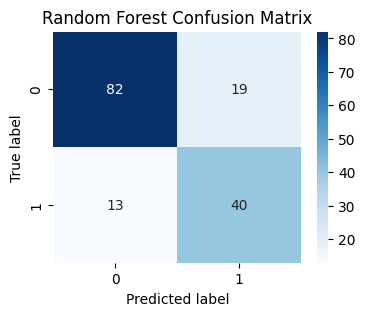

In [91]:
# Compute accuracy score
rf_acc_score = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Test Accuracy Score: {rf_acc_score}')

# Generate confusion matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)
print(f'\nRandom Forest Confusion Matrix:\n{rf_cm}')

# Plot confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# SVM

In [95]:
best_svm_model=SVC()
best_svm_model.fit(X_train,y_train)

SVC()

In [96]:
y_pred_svm=best_svm_model.predict(X_test)

SVM Regression Test Accuracy Score: 0.7922077922077922

SVM Regression Confusion Matrix:
[[83 18]
 [14 39]]


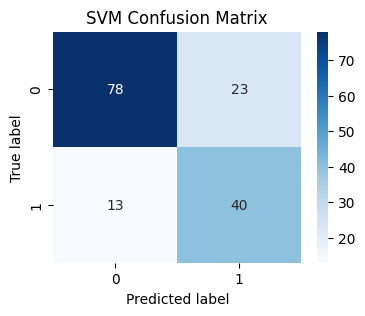

In [98]:
svm_acc_score = accuracy_score(y_test, y_pred_svm)
print(f'SVM Regression Test Accuracy Score: {lg_acc_score}')

# Generate confusion matrix
svm_cm = confusion_matrix(y_test, y_pred_svm)
print(f'\nSVM Regression Confusion Matrix:\n{lg_cm}')

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()